# Name: Luke Pratley

# Testing Basic UNet

In [1]:
import os
import numpy as np

import tensorflow.keras 
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import PIL
import matplotlib.pyplot as plt
import pandas as pd

import math

import glob
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

sys.path.append('..')

import building_road_segmentation.unet_factory as unet_factory
import building_road_segmentation.optimization_factory as optimization_factory
import building_road_segmentation.data_generator as data_generator
import building_road_segmentation.loss_functions as loss_functions

Num GPUs Available:  1


In [2]:
image_dir =  glob.glob("..\\data_cleaning_EDA\\final_images_small\\*AOI_2*") + glob.glob("..\\data_cleaning_EDA\\final_images_small\\*AOI_3*") + glob.glob("..\\data_cleaning_EDA\\final_images_small\\*AOI_4*") + glob.glob("..\\data_cleaning_EDA\\final_images_small\\*AOI_5*")
mask_dir =  glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*AOI_2*") + glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*AOI_3*") + glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*AOI_4*") + glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*AOI_5*")
filt_image_dir = []
filt_mask_dir = []
for p in range(len(image_dir)):
    s1 = image_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.png', '')
    s2 = mask_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.npy', '')
    assert s1 == s2
    mask = np.load(mask_dir[p])
    if (mask[:, :, 0] > 0).any() and (mask[:, :, 1] > 0).any():
        filt_image_dir.append(image_dir[p])
        filt_mask_dir.append(mask_dir[p])
    
assert len(mask_dir) == len(image_dir)
print(len(image_dir))

16739


In [3]:
len(filt_image_dir)

8948

In [4]:
train_image_dir, test_image_dir, train_mask_dir, test_mask_dir = train_test_split(filt_image_dir, filt_mask_dir, test_size=0.3, random_state=42)
train_image_dir, val_image_dir, train_mask_dir, val_mask_dir = train_test_split(train_image_dir, train_mask_dir, test_size=0.2, random_state=42)

In [5]:
train_data = data_generator.READ_AND_AUGMENT_DATA(train_image_dir, train_mask_dir, batch_size=64)
val_data = data_generator.READ_AND_AUGMENT_DATA(val_image_dir, val_mask_dir, batch_size=128)
test_data = data_generator.READ_AND_AUGMENT_DATA(test_image_dir, test_mask_dir, batch_size=128)

In [6]:
losses = {'dice_loss' : loss_functions.weighted_dice_loss([1, 1]), 'BinaryCrossentropy': loss_functions.weighted_binary_crossentropy(np.array([1, 1]))}

In [7]:
model_configurations = {
                        'efficient_model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'},
                        'efficient_model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'},
#                        'model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'},
#                        'model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'},
#                        'res_model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'dice_loss'},
#                        'res_model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': True, 'loss': 'BinaryCrossentropy'},
#                        'attention_model_1': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'},
#                        'attention_model_2': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'},
                       }
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [8]:
len(model_configurations)

2

In [9]:
retrain=False

In [ ]:
for model_name, model_config in model_configurations.items():
    print(model_name, model_config)
    tf.keras.backend.clear_session()
    if not os.path.exists(model_name):
        if model_name.split('_')[0] =='efficient':
                    unet_model = unet_factory.EfficientNetUNet(efficientnet=tensorflow.keras.applications.efficientnet.EfficientNetB4,
                                            number_of_categories=2,
                                            unet_levels=model_config['unet_levels'],
                                            number_of_start_kernels=model_config['number_of_start_kernels'],
                                            kernel_shape=(3, 3),
                                            activation='relu',
                                            final_activation='sigmoid',
                                            pooling_amount=model_config['pooling_amount'],
                                            dropout_rate=0.2, residual=model_config['residual'])
        if model_name.split('_')[0] =='attention':
            unet_model = unet_factory.BasicUNet(number_of_categories=2,
                                            unet_levels=model_config['unet_levels'],
                                            number_of_start_kernels=model_config['number_of_start_kernels'],
                                            kernel_shape=(3, 3),
                                            activation='relu',
                                            final_activation='sigmoid',
                                            pooling_amount=model_config['pooling_amount'],
                                            dropout_rate=0.2, residual=model_config['residual'])
        else:
            unet_model = unet_factory.BasicUNet(number_of_categories=2,
                                            unet_levels=model_config['unet_levels'],
                                            number_of_start_kernels=model_config['number_of_start_kernels'],
                                            kernel_shape=(3, 3),
                                            activation='relu',
                                            final_activation='sigmoid',
                                            pooling_amount=model_config['pooling_amount'],
                                            dropout_rate=0.2, residual=model_config['residual'])

    else:
        if retrain:
            unet_model = tf.keras.models.load_model(model_name, custom_objects={model_config['loss']: losses[model_config['loss']]})
    if not os.path.exists(model_name) or retrain:
        modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                            monitor='val_iou_metric',
                            mode='max',
                            save_best_only=True, save_format='tf')
        unet_model.compile(optimizer=optimizer, loss=losses[model_config['loss']], metrics=[loss_functions.masked_accuracy(), loss_functions.iou_metric])
        history = unet_model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[modelcheckpoint])
        history =  pd.DataFrame(history.history)
        if os.path.exists(f'{model_name}_history.csv'):
            history_old = pd.read_csv(model_name +'_history.csv', index_col=0)
            history = pd.concat((history_old , history), axis=0, ignore_index=True)
        history.to_csv(f'{model_name}_history.csv')  
        break

efficient_model_1 {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}
efficient_model_2 {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}
Epoch 1/100
127/392 [========>.....................] - ETA: 1:43 - loss: 0.3648 - accuracy: 0.8500 - iou_metric: 0.2037

efficient_model_1
efficient_model_2


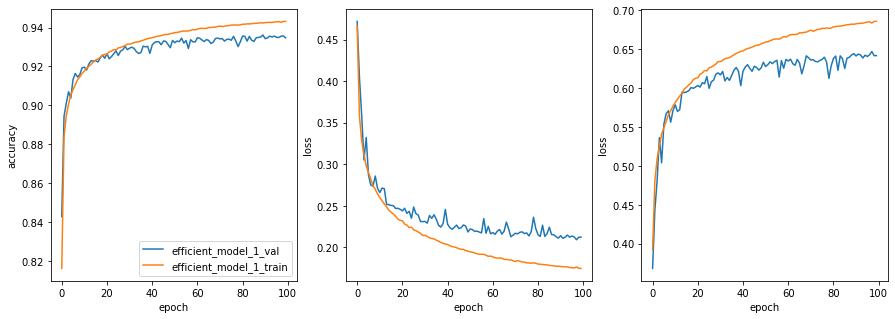

In [12]:
histories = {}
count = 0
fig, ax = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(15,5))
for model_name, model_config in model_configurations.items():
    print(model_name)
    if os.path.exists(model_name):
        history = pd.read_csv(model_name +'_history.csv', index_col=0)
        histories[model_name] = history
        if np.mean(history['val_loss']) <0.5:    
            ax[0].plot(history['val_accuracy'], label=model_name+'_val')
            ax[0].set_ylabel('accuracy')
            ax[0].plot(history['accuracy'], label=model_name +'_train')
            ax[0].set_ylabel('accuracy')
            ax[0].set_xlabel('epoch')
            ax[1].plot(history['val_loss'])
            ax[1].plot(history['loss'])
            ax[1].set_ylabel('loss')
            ax[1].set_xlabel('epoch')
            ax[2].plot(history['val_iou_metric'])
            ax[2].plot(history['iou_metric'])
            ax[2].set_ylabel('loss')
            ax[2].set_xlabel('epoch')
ax[0].legend()
plt.show()

In [13]:
X_test = np.array([np.array(PIL.Image.open(im)).astype(float) for im in test_image_dir])

In [14]:
y_test = np.array([
            np.load(file_name)
               for file_name in test_mask_dir])

In [15]:
model_metrics = {}
for k, (model_name, model_config) in enumerate(model_configurations.items()):
    if os.path.exists(model_name):
        model_metrics[model_name] = {'road_iou': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []}, 
                                 'building_iou': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []},
                                    'road_file': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []},
                                    'road_index': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []},
                                    'building_file': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []},
                                    'building_index': {'AOI_2_Vegas': [], 'AOI_3_Paris': [], 'AOI_4_Shanghai' : [], 'AOI_5_Khartoum': []},
                                    }
        tf.keras.backend.clear_session()
        final_model = tf.keras.models.load_model(model_name, custom_objects={model_config['loss']: losses[model_config['loss']], 'iou_metric': loss_functions.iou_metric})
        print(model_name, model_config)
        y_pred = final_model.predict(X_test/255)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        for k in range(y_test.shape[0]):
            for key in model_metrics[model_name]['road_iou'].keys():
                if key in test_mask_dir[k]:
                    if np.sum(y_test[k, :, :, 0]) > 0:
                        model_metrics[model_name]['road_iou'][key].append(loss_functions.intersection_over_union(y_test[k, :, :, 0], y_pred[k, :, :, 0]))
                        model_metrics[model_name]['road_file'][key].append(test_mask_dir[k])
                        model_metrics[model_name]['road_index'][key].append(k)
                    if np.sum(y_test[k, :, :, 1]) > 0:
                        model_metrics[model_name]['building_iou'][key].append(loss_functions.intersection_over_union(y_test[k, :, :, 1], y_pred[k, :, :, 1]))
                        model_metrics[model_name]['building_file'][key].append(test_mask_dir[k])
                        model_metrics[model_name]['building_index'][key].append(k)

efficient_model_1 {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}


In [16]:
def plot_metrics(model_metrics, model_name):
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 2))
    plt.suptitle(f'Road Average IoU per Image ({model_name})')
    ax = np.ravel(ax)
    all_values = []
    for k, key in enumerate(model_metrics[model_name]['road_iou'].keys()):
        all_values = np.concatenate((all_values, model_metrics[model_name]['road_iou'][key]))
        model_metrics[model_name]['road_iou'][key] = np.array(model_metrics[model_name]['road_iou'][key])
        
        ax[k].hist(model_metrics[model_name]['road_iou'][key], density=True, alpha=0.5, bins=np.arange(0, 1.05, 0.05), label=key, color=['green', 'red', 'navy', 'purple'][k])
        ax[k].legend()
        ax[k].set_xlabel('IoU')
        ax[k].axvline(np.median(model_metrics[model_name]['road_iou'][key]))
    print(np.median(all_values))
    ax[0].set_ylabel('Density')
    plt.show()
    all_values = []
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 2))
    fig.suptitle(f'Building Average IoU per Image ({model_name})')
    ax = np.ravel(ax)
    for k, key in enumerate(model_metrics[model_name]['building_iou'].keys()):
        all_values = np.concatenate((all_values, model_metrics[model_name]['building_iou'][key]))
        model_metrics[model_name]['building_iou'][key] = np.array(model_metrics[model_name]['building_iou'][key])
        ax[k].hist(model_metrics[model_name]['building_iou'][key], density=True, alpha=0.5, bins=np.arange(0, 1.05, 0.05), label=key, color=['green', 'red', 'navy', 'purple'][k])
        ax[k].legend()
        ax[k].set_xlabel('IoU')
        ax[k].axvline(np.median(model_metrics[model_name]['building_iou'][key]))
    print(np.median(all_values))
    ax[0].set_ylabel('Density')
    plt.show()

efficient_model_1 {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}
0.6614692653673163


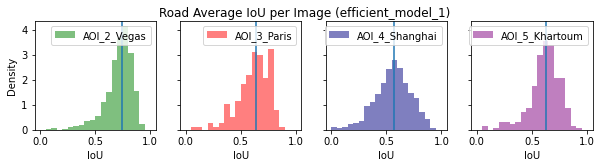

0.7128146453089245


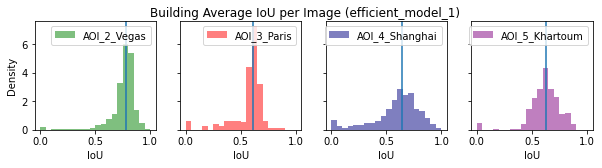

In [17]:
for model_name in model_configurations.keys():
    if os.path.exists(model_name):
        if np.mean(histories[model_name]['val_loss']) < 0.5:
            print(model_name, model_configurations[model_name])
            plot_metrics(model_metrics, model_name)

In [18]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_result(X_test, y_test, model_name, display_prob, index=0):
        final_model = tf.keras.models.load_model(model_name, custom_objects={model_config['loss']: losses[model_config['loss']], 'iou_metric': loss_functions.iou_metric})
        y_pred = final_model.predict(X_test)
        if not display_prob:
            y_pred = np.where(y_pred > 0.5, 1, 0)
        fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
        ax[1, 0].set_title('Image')
        ax[1, 0].imshow(X_test_batch[index, :, :])
        ax[0, 0].set_title('Labels')
        ax[0, 0].imshow(y_test[index, :, :, 0] * 10 + y_test[index, :, :, 1] * 20, cmap = ListedColormap(['navy','green','purple']))
        ax[0, 0].legend(handles=[Patch(facecolor='navy', edgecolor='navy',
                         label='Background'), Patch(facecolor='green', edgecolor='green',
                         label='Road Network'), Patch(facecolor='purple', edgecolor='purple',
                         label='Building')], loc="best", bbox_to_anchor=(1.05, 1))
        ax[1, 1].set_title('True Road Network')
        ax[1, 1].imshow(y_test[index, :, :, 0], vmin = 0, vmax=1)
        ax[1, 2].set_title('True Building Footprint')
        ax[1, 2].imshow(y_test[index, :, :, 1], vmin = 0, vmax=1)
        ax[0, 1].set_title('Predicted Road Network')
        ax[0, 1].imshow(y_pred[index, :, :, 0], vmin = 0, vmax=1)
        ax[0, 2].set_title('Predicted Building Footprint')
        ax[0, 2].imshow(y_pred[index, :, :, 1], vmin = 0, vmax=1)

In [19]:
model_name ='efficient_model_1'
areas_of_interest = model_metrics[model_name]['building_index'].keys()
best_building_index = [model_metrics[model_name]['building_index'][k][np.argmax(model_metrics[model_name]['building_iou'][k])] for k in areas_of_interest]
best_road_index = [model_metrics[model_name]['road_index'][k][np.argmax(model_metrics[model_name]['road_iou'][k])] for k in areas_of_interest]
median_building_index = [model_metrics[model_name]['building_index'][k][np.argmin(np.abs(np.median(model_metrics[model_name]['building_iou'][k]) - model_metrics[model_name]['building_iou'][k]))] for k in areas_of_interest]
median_road_index = [model_metrics[model_name]['road_index'][k][np.argmin(np.abs(np.median(model_metrics[model_name]['road_iou'][k]) - model_metrics[model_name]['road_iou'][k]))] for k in areas_of_interest]

1518
('..\\data_cleaning_EDA\\final_images_small\\AOI_2_Vegas_img4249.png', <Augment.ORIGINAL: 1>)
('..\\data_cleaning_EDA\\final_masks_small\\AOI_2_Vegas_img4249.npy', <Augment.ORIGINAL: 1>)
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}


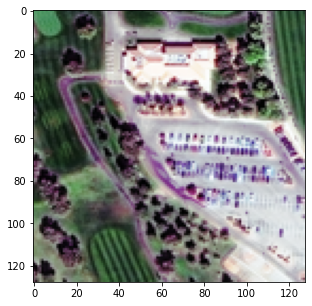

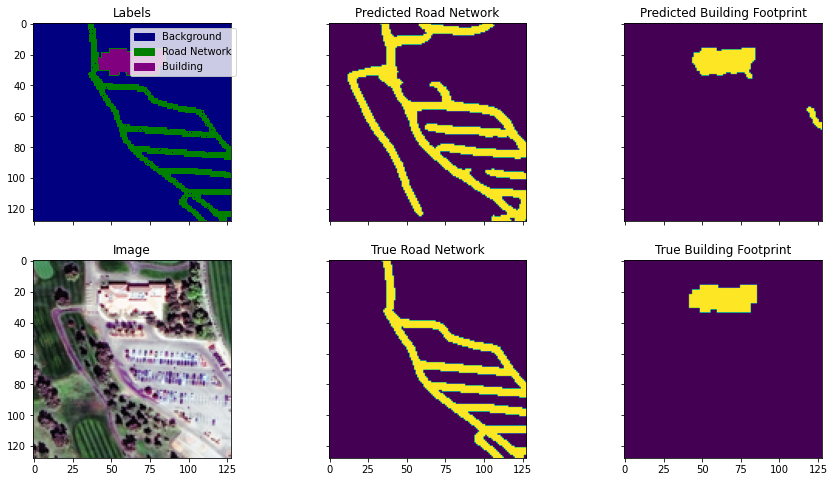

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}


In [29]:
k= median_building_index[0]
print(k)

batch = math.floor(k / test_data.batch_size) 
index = k - batch * test_data.batch_size
print(test_data.x[k])
print(test_data.y[k])
X_test_batch, y_test_batch = test_data.__getitem__(batch)
plt.figure(figsize=(5, 5))
plt.imshow(X_test_batch[index, :, :])
for model_name, model_config in model_configurations.items():
    print(model_config)
    if os.path.exists(model_name):
        plot_result(X_test_batch, y_test_batch, model_name=model_name, display_prob=False, index=index)
        plt.show()

('..\\data_cleaning_EDA\\final_images_small\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img1427_c.png', <Augment.ORIGINAL: 1>)
('..\\data_cleaning_EDA\\final_masks_small\\SN3_roads_train_AOI_2_Vegas_PS-RGB_img1427_c.npy', <Augment.ORIGINAL: 1>)
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'dice_loss'}


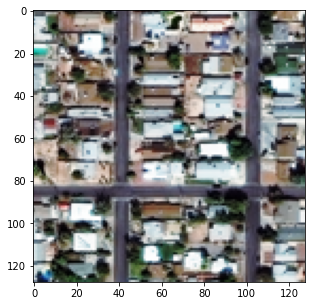

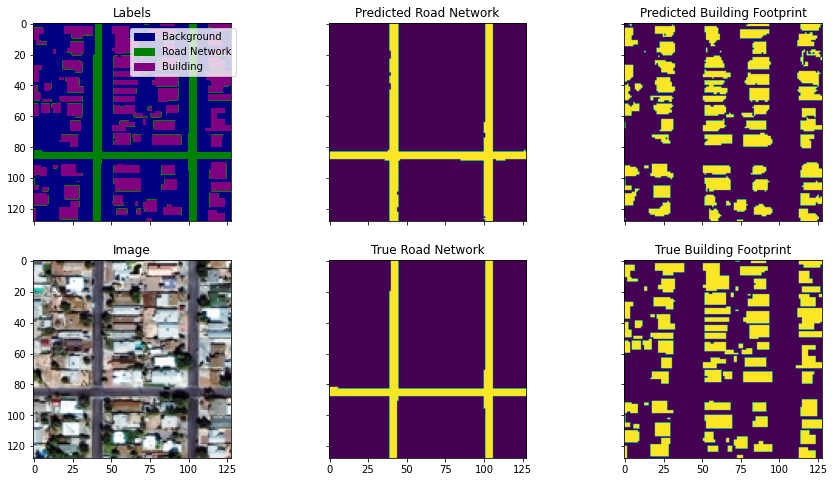

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2, 'residual': False, 'loss': 'BinaryCrossentropy'}


In [34]:
k= best_road_index[0]

batch = math.floor(k / test_data.batch_size) 
index = k - batch * test_data.batch_size
print(test_data.x[k])
print(test_data.y[k])
X_test_batch, y_test_batch = test_data.__getitem__(batch)
plt.figure(figsize=(5, 5))
plt.imshow(X_test_batch[index, :, :])
for model_name, model_config in model_configurations.items():
    print(model_config)
    if os.path.exists(model_name):
        plot_result(X_test_batch, y_test_batch, model_name=model_name, display_prob=False, index=index)
        plt.show()